# Sloan Digital Sky Survey Classification
Notre projet se porte sur la classification d'objets célestes en STAR, GALAXY et QUASAR (multiclass classification). 

Le dataset initial contient 100.000 lignes de 18 features (en comptant la classe).

Class 0 = GALAXY | 
Class 1 = QUASAR | 
Class 2 = STAR



#### description des features selon le site source : 

u = better of deV/Exp magnitude fit (u-band)

g = better of deV/Exp magnitude fit (g-band)

r = better of deV/Exp magnitude fit (r-band)

i = better of deV/Exp magnitude fit (i-band)

z = better of deV/Exp magnitude fit (z-band)

redshift = Final Redshift

Les autres features sont essentiellements des caractéristiques de la prise d'images ainsi que des identifiants.

#### Lien vers le dataset : 

https://www.kaggle.com/muhakabartay/sloan-digital-sky-survey-dr16 

#### Membres du groupe : 

- Team preprocessing : MOKHTARI Yacine, ATTOUCHE Lynda 
- Team model : IZRI Lilia, SOLIMAN Romain
- Team visualization : ISKOUNEN Feriel, NDAO Ndieme

# Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd

#Preprocessing
from sklearn import preprocessing
from sklearn import model_selection

#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis & Preprocessing

In [2]:
##reading data with pandas
df= pd.read_csv('dataset.csv')
## Taking a peak at the data
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


In [3]:
#test if the data contains null values
print('Nan value',df.isnull().sum())

Nan value objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64


In [4]:
#take a look at the column of the dataframe to see the features
df.columns


Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [5]:
#number of data in each class
df['class'].value_counts()

GALAXY    51323
STAR      38096
QSO       10581
Name: class, dtype: int64

### Data Distribution 

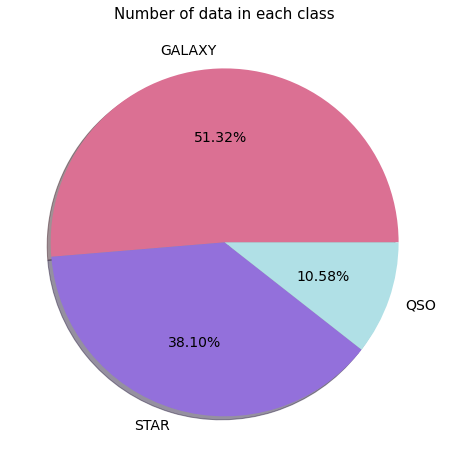

In [6]:
plt.figure(figsize=(8,8))
plt.pie(df["class"].value_counts(),labels=df["class"].value_counts().index,autopct=lambda p:f'{p:.2f}%',
        shadow=True,colors=['palevioletred','mediumpurple','powderblue'],labeldistance = 1.1,textprops={'fontsize': 14})

plt.title("Number of data in each class",fontsize = 15, color="black")
#plt.savefig("distribution des données dans les différentes classes.png")
plt.show()

#### Note :
Nous observons que la distribution des données dans les 3 classes est déséquilibrée. En outre, nous pouvons voir que la classe des galaxies contient la plus grande quantité de données (plus de 50%), la classe des étoiles environ 39% et la classe des QSO 11%.

 C'est pourquoi nous allons faire un over-resampling, en dupliquant les données dans les classes minoritaires afin d'avoir le même nombre de données que la classe galaxie. Nous ferons cela après avoir divisé notre ensemble en 3 sous-ensembles (train,test & valide set).

### Features Distribution 

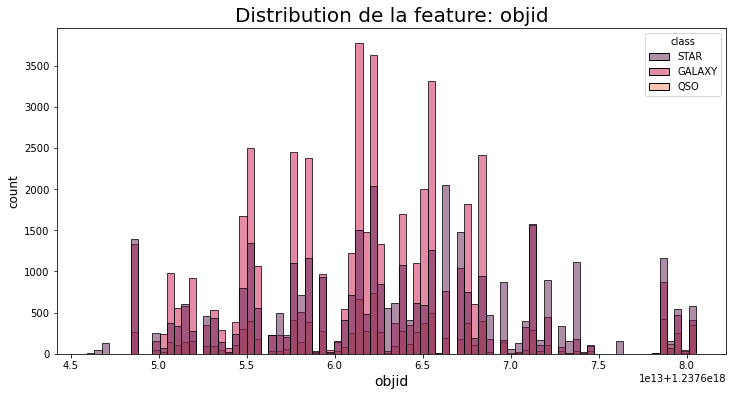

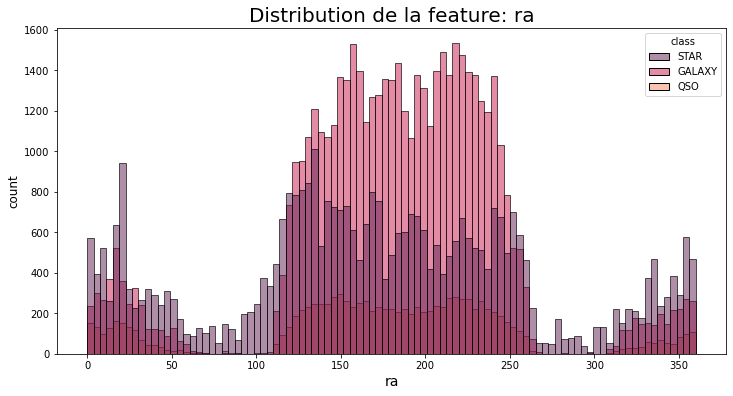

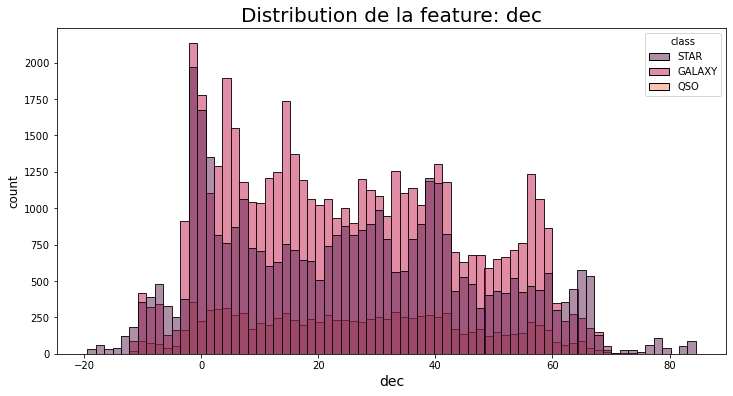

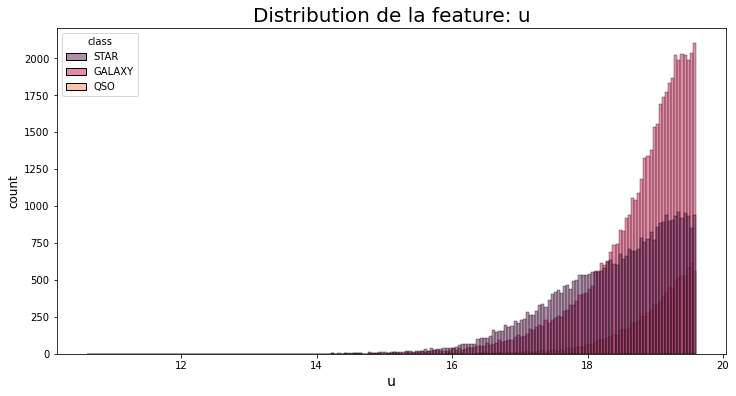

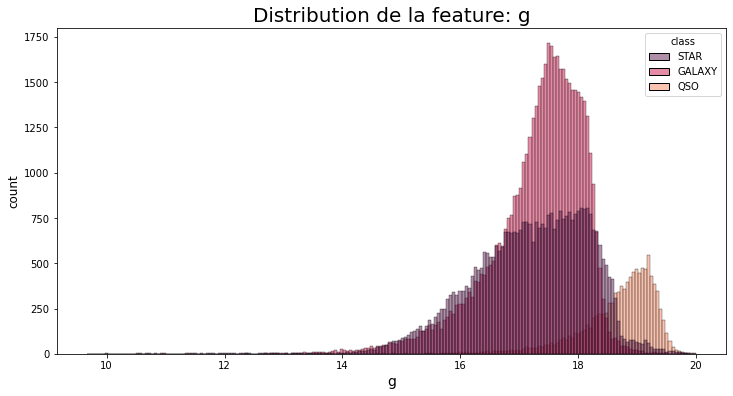

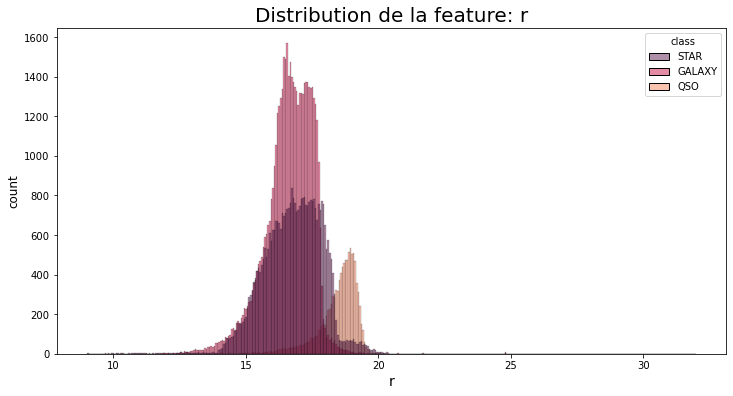

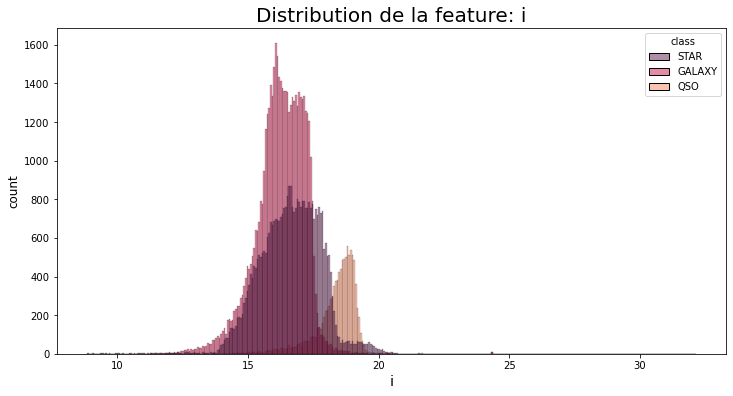

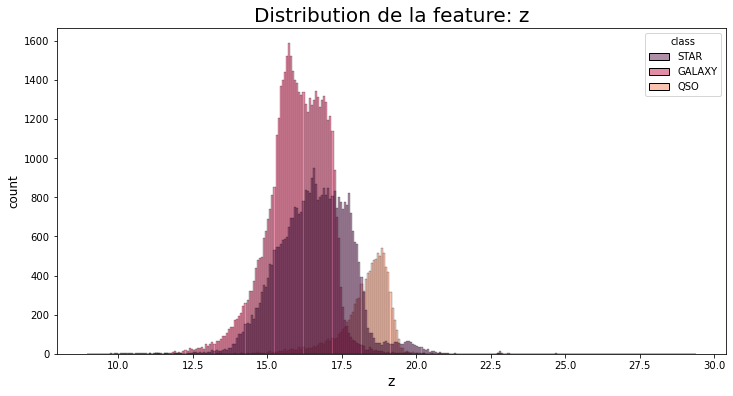

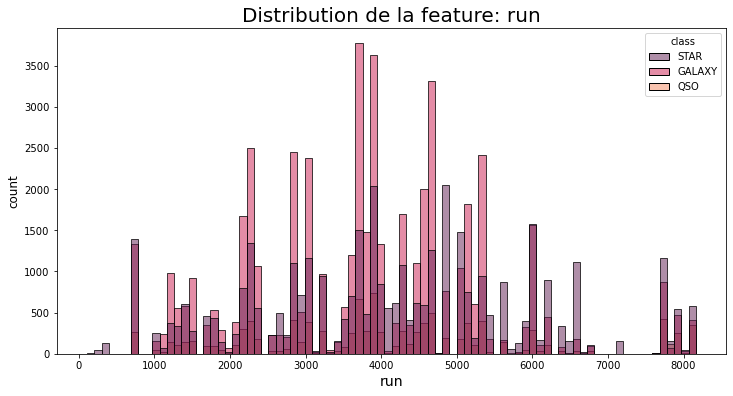

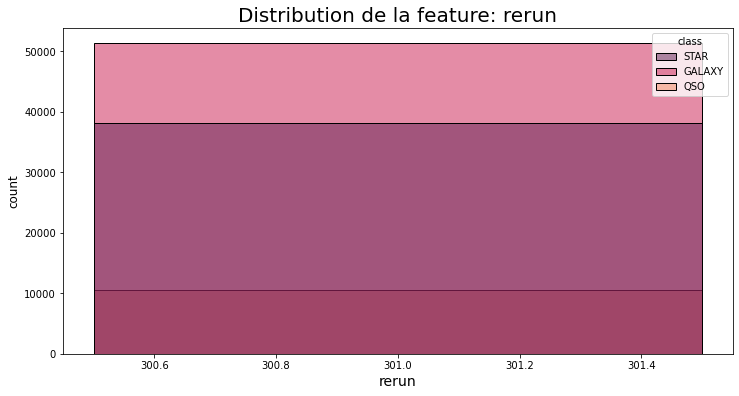

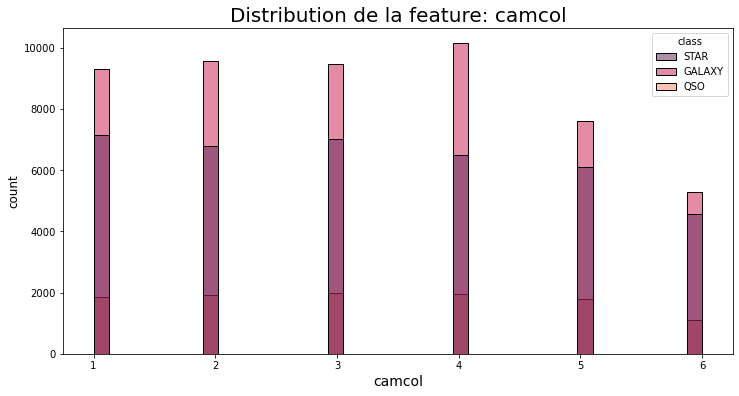

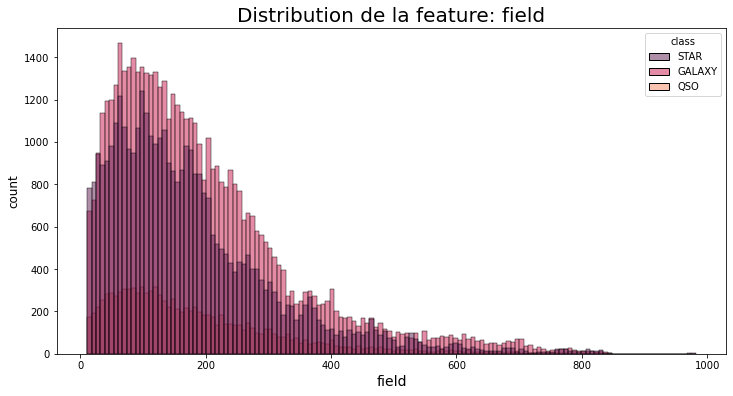

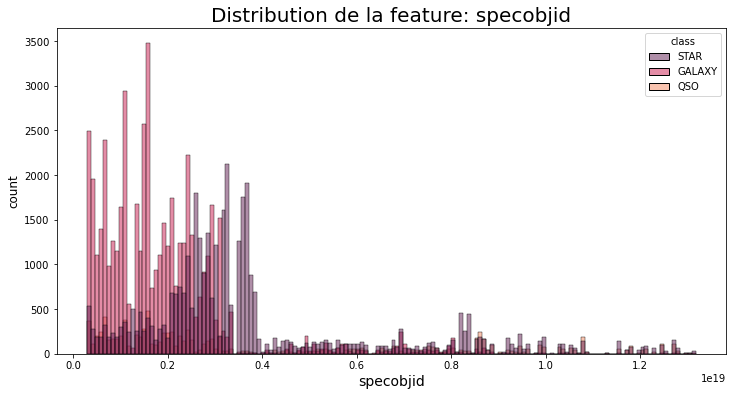

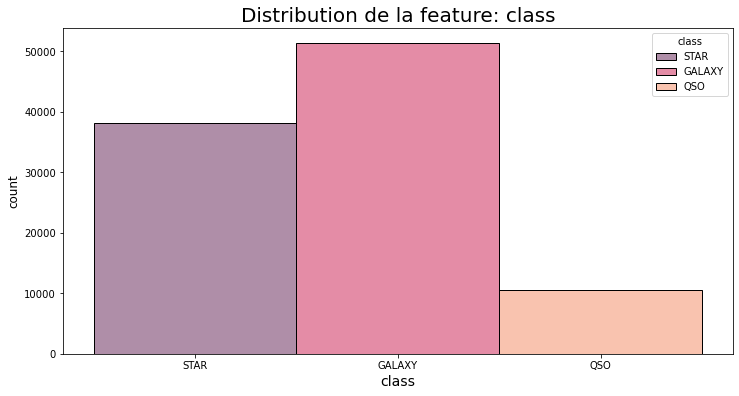

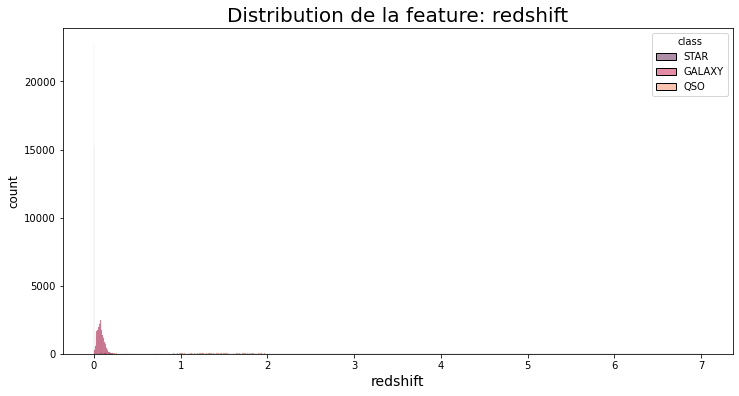

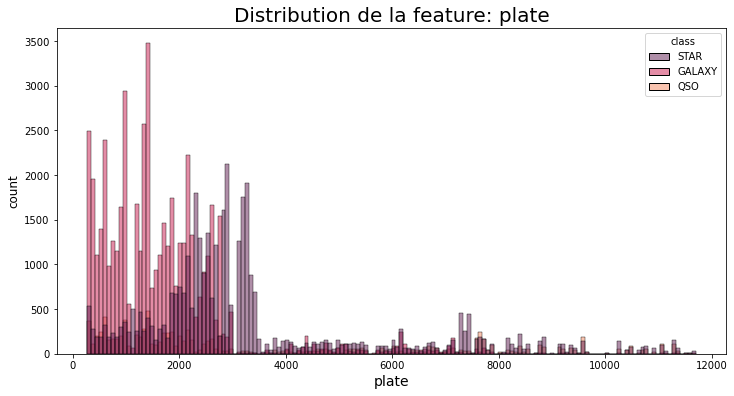

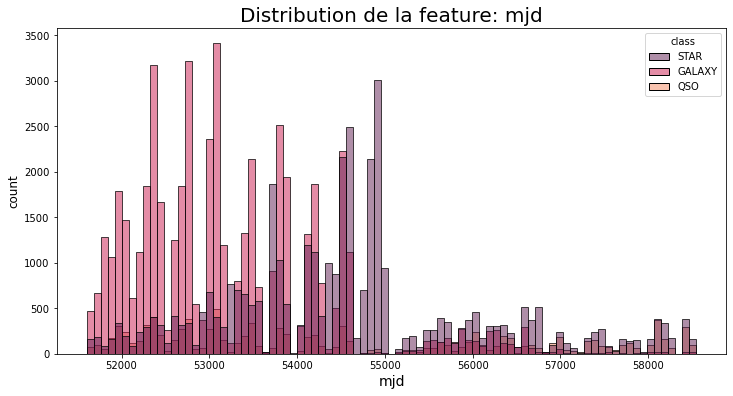

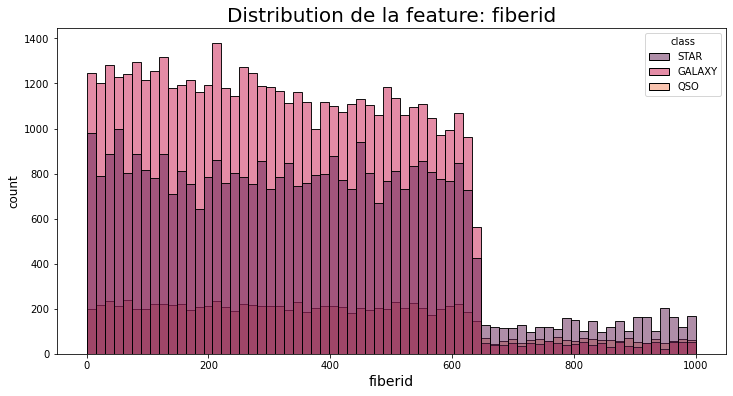

In [7]:
for i in df.columns:
    plt.figure(figsize=(12,6))
    g=sns.histplot(data = df,x = df[i], hue = 'class', palette='rocket')
    g.set_xlabel(i,fontsize=14)
    g.set_ylabel("count",fontsize=12)
    title = ("Distribution de la feature: "+ str(i))
    plt.title(title,fontsize = 20)
    #plt.savefig(i)
   

#### Note : 
Nous remarquons que certaines features sont insignifiantes et n'apportent pas des informations concernant les caractéristiques des objets. 

Les features en question sont : 'objid', 'ra','dec', 'run', 'rerun', 'camcol', 'field','specobjid', 'pl. C'est donc pour cela que nous allons nous séparer d'elles pour la suite.

In [8]:
# we remove useless features by deleting their columns in the data frame
df_features = df.drop(columns=['objid', 'ra','dec', 'run', 'rerun', 'camcol', 'field','specobjid', 'plate', 'mjd', 'fiberid'])
df_features

,u,g,r,i,z,class,redshift
0,18.69254,17.13867,16.55555,16.34662,16.17639,STAR,0.000115
1,18.47633,17.30546,17.24116,17.32780,17.37114,STAR,-0.000093
2,16.47714,15.31072,15.55971,15.72207,15.82471,STAR,0.000165
3,18.63561,16.88346,16.09825,15.70987,15.43491,GALAXY,0.058155
4,18.88325,17.87948,17.47037,17.17441,17.05235,GALAXY,0.072210
...,...,...,...,...,...,...,...
99995,19.32631,18.82748,18.65659,18.60481,18.60917,QSO,0.438182
99996,18.33687,17.30365,17.16037,17.14895,17.14419,STAR,-0.000497
99997,17.50690,15.63152,15.22328,15.04469,15.28668,GALAXY,0.004587
99998,19.33946,17.21436,16.29697,15.86745,15.51556,GALAXY,0.084538


In [9]:
df_features.describe()

,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,18.637915,17.407128,16.881676,16.625534,16.467087,0.170621
std,0.832284,0.985921,1.133337,1.209532,1.281788,0.437571
min,10.611810,9.668339,9.005167,8.848403,8.947795,-0.004136
25%,18.212902,16.852982,16.196608,15.865275,15.619960,0.000001
50%,18.873250,17.515860,16.890640,16.599885,16.428385,0.045997
75%,19.273302,18.056060,17.585750,17.344912,17.234625,0.095429
max,19.599950,19.996050,31.990100,32.141470,29.383740,7.011245


### Encoding Class Labels to Integers

In [10]:
# On utilisera l'encoder de scikit-learn
le = preprocessing.LabelEncoder()
labels = le.fit_transform(df_features["class"])

In [11]:
df_features["class"] = labels

### Features correlation

Text(0.5, 1.0, 'Matrice de corrélation')

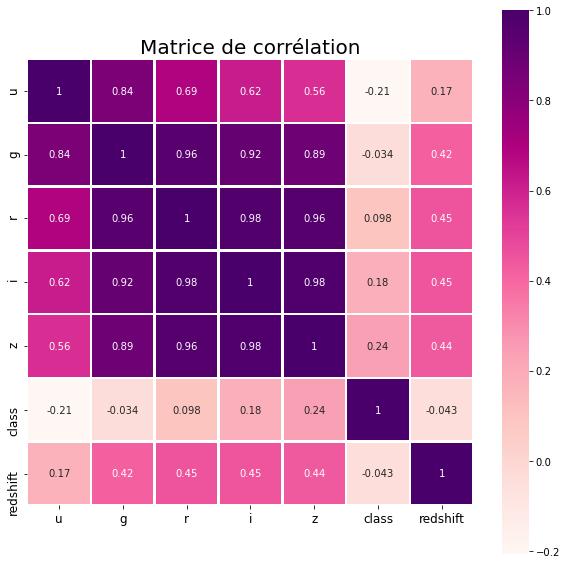

In [12]:
fig=plt.figure(figsize = (10,10))
g=sns.heatmap(df_features.corr(),annot=True, cmap="RdPu",square=True,linewidth=1.5)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 12)
g.set_title('Matrice de corrélation',fontsize=20)
#plt.savefig('Matrice de corrélation.png') 


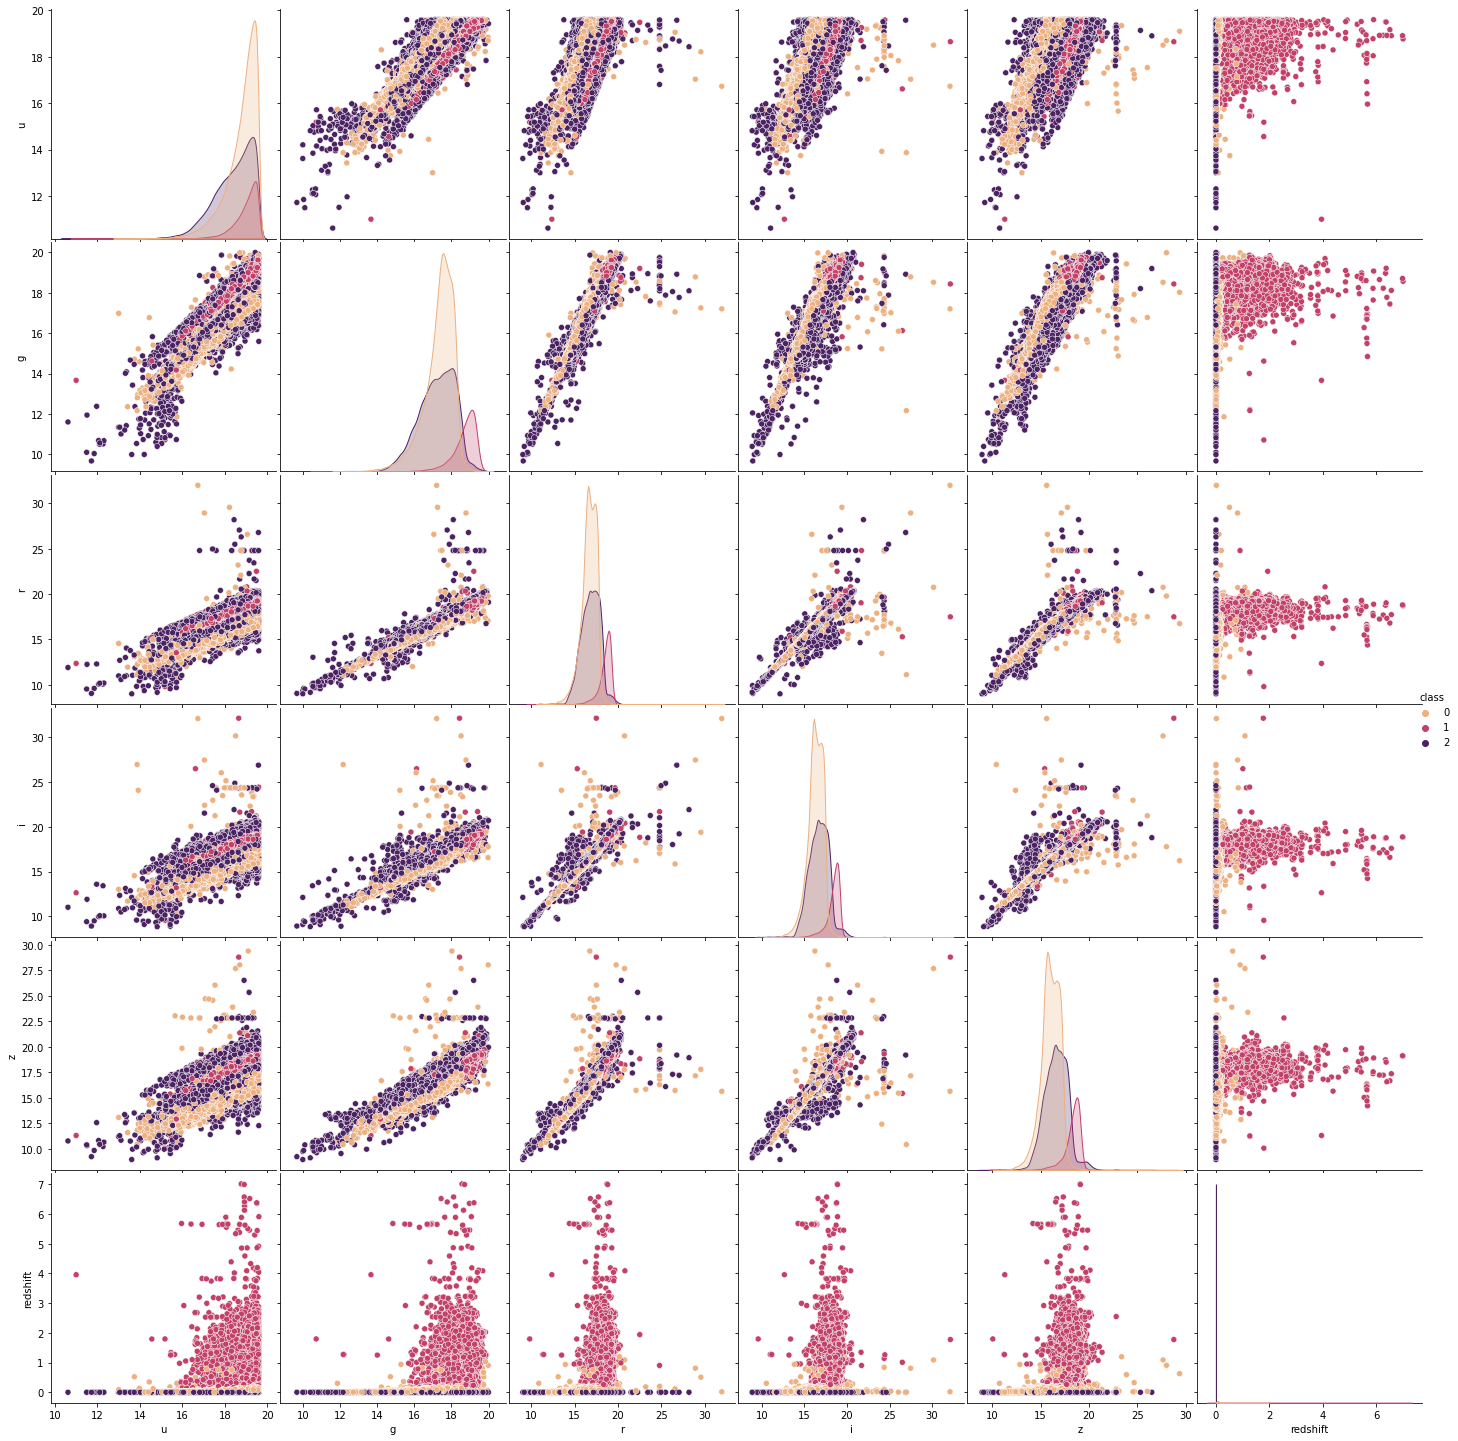

In [13]:
# relation entre les données
# prend un peu de temps 
'''
g=sns.pairplot(df_features, hue='class', height=8, palette='flare')
g.fig.set_size_inches(20,20)
'''

#### Note : 
Nous constatons que les features u,g,r,i,z sont fortement corrélées.

### Features Standardization

Vue la présence de certaines valeurs aberrantes nous allons mettre à l'échelle les données.

In [14]:
# On utilisera la standarisation de scikit-learn
df_features = df_features.drop(columns=["class"])
scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(df_features)
scaled_features

array([[ 0.06563335, -0.27229321, -0.2877591 , -0.23059775, -0.22679103,
        -0.38966862],
       [-0.19414721, -0.10312061,  0.31719185,  0.58061255,  0.70530996,
        -0.39014263],
       [-2.59621319, -2.12635553, -1.16644284, -0.74695702, -0.50115912,
        -0.38955451],
       ...,
       [-1.35893636, -1.80097289, -1.4632933 , -1.30699456, -0.92091078,
        -0.37944848],
       [ 0.84292041, -0.19552198, -0.51591829, -0.62676118, -0.74234683,
        -0.19673194],
       [-0.6250602 , -0.55211417, -0.50391827, -0.4544871 , -0.40574506,
        -0.390124  ]])

In [15]:
scaled_features.shape

(100000, 6)

In [16]:
df_features.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift'], dtype='object')

In [17]:
# Convert numpy array to panda dataframe
df_temp = pd.DataFrame(scaled_features, columns=df_features.columns)
df_temp

,u,g,r,i,z,redshift
0,0.065633,-0.272293,-0.287759,-0.230598,-0.226791,-0.389669
1,-0.194147,-0.103121,0.317192,0.580613,0.705310,-0.390143
2,-2.596213,-2.126356,-1.166443,-0.746957,-0.501159,-0.389555
3,-0.002769,-0.531149,-0.691260,-0.757044,-0.805267,-0.257025
4,0.294775,0.479099,0.519436,0.453794,0.456601,-0.224904
...,...,...,...,...,...,...
99995,0.827120,1.440641,1.566103,1.636406,1.671176,0.611473
99996,-0.361711,-0.104956,0.245906,0.432745,0.528252,-0.391067
99997,-1.358936,-1.800973,-1.463293,-1.306995,-0.920911,-0.379448
99998,0.842920,-0.195522,-0.515918,-0.626761,-0.742347,-0.196732


### Splitting Data into Train & Test Set

In [18]:
# Décomposition de notre jeu de données en ensemble d'entrainement,de validation et de test 
test_ratio = 0.2
val_ratio = 0.3
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_temp, labels, test_size = test_ratio)
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, test_size = val_ratio)

X_train

,u,g,r,i,z,redshift
32334,0.986154,0.195566,-0.045129,-0.079150,-0.087859,-0.389873
38539,0.441973,0.126128,0.066374,0.105600,0.140339,-0.390344
70772,-0.524361,-0.860041,-0.842425,-0.763013,-0.677796,-0.390260
73575,0.153705,-0.417387,-0.759122,-0.903638,-1.034011,-0.315018
50598,0.977250,0.195809,-0.202577,-0.306239,-0.420092,-0.092432
...,...,...,...,...,...,...
84732,-1.136523,-0.847007,-0.616401,-0.487087,-0.372760,-0.389864
85195,1.002819,0.885219,0.853116,0.885922,0.946466,-0.390831
51905,-0.890007,-0.427956,-0.156085,-0.012157,0.084440,-0.389582
61229,-0.045075,-0.039951,-0.029300,-0.018076,-0.001831,-0.389584


### Resampling Data
Comme cité au début, nous effectuerons un réequilibrage sur l'ensemble d'entraînement, de validation et de test.

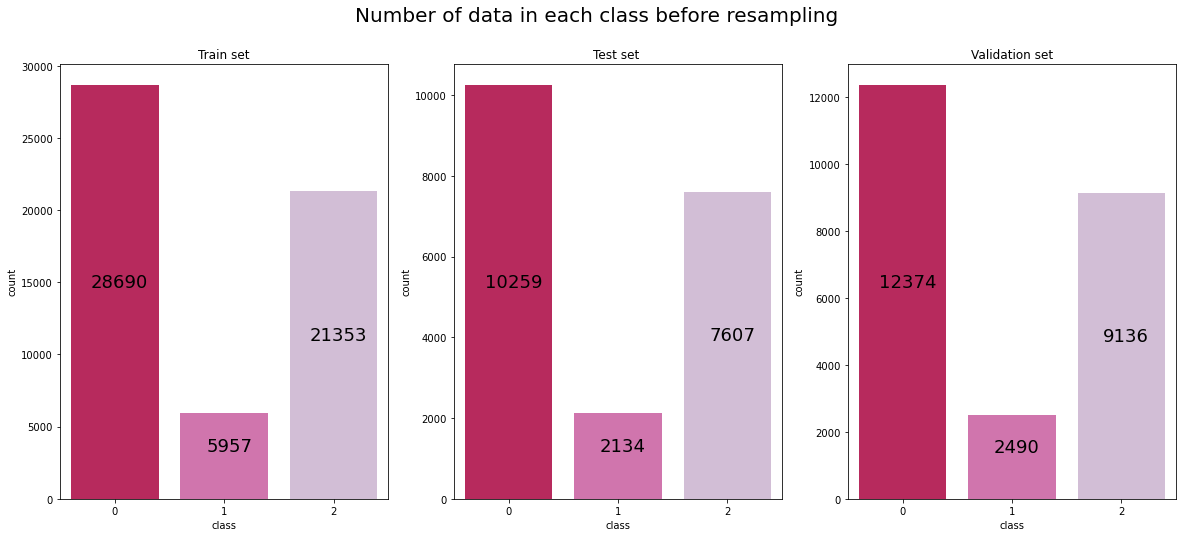

In [19]:
train_set = X_train.copy()
test_set = X_test.copy()
val_set = X_val.copy()
train_set.insert(0, "class", Y_train, True)
test_set.insert(0, "class", Y_test, True)
val_set.insert(0, "class", Y_val, True)

fig,ax= plt.subplots(1,3,figsize=(20,8))
sns.countplot(x="class", data=train_set, palette='PuRd_r',ax=ax[0])
ax[1] = sns.countplot(x="class", data=test_set, palette='PuRd_r',ax=ax[1])
ax[2] = sns.countplot(x="class", data=val_set, palette='PuRd_r',ax=ax[2])

ax[0].set_title('Train set')
ax[1].set_title('Test set ')
ax[2].set_title('Validation set')

fig.suptitle('Number of data in each class before resampling ', fontsize=20)

for i in range(3):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()/2), 
        ha = 'center', va = 'center', xytext = (5, 10), textcoords = 'offset points',size=18,color='black')

In [20]:
# Fonction pour réequilibrer les classes utilisant sample de pandas
def resample(X, y):
    Xnew = X.copy()
    ynew = y.copy()
    setnew = Xnew
    setnew.insert(0, "class", ynew, True)


    class0,class1,class2 = setnew[setnew['class'] == 0], setnew[setnew['class'] == 1], setnew[setnew['class'] == 2]
    count_class_0, count_class_1,count_class_2 = Xnew['class'].value_counts()
  


    class1_sampled = class1.sample(count_class_0, replace=True) #le .sample permet d'avoir des objets randoms
    class2_sampled = class2.sample(count_class_0, replace=True)

    setnew_resampled = pd.concat([class0, class1_sampled,class2_sampled], axis=0)

    ynew = setnew_resampled['class']
    Xnew = setnew_resampled.drop(columns=["class"])
    return Xnew, ynew


In [21]:
#Réequilibre tous les ensembles 
X_train, Y_train = resample(X_train, Y_train)
X_val, Y_val = resample(X_val, Y_val)
X_test, Y_test = resample(X_test, Y_test)

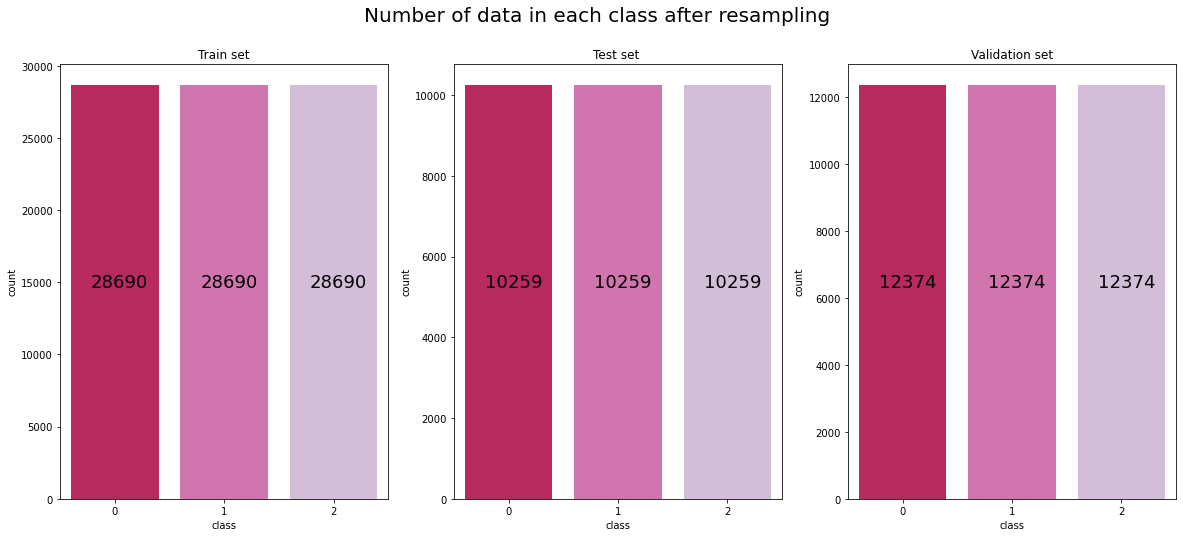

In [22]:
train_set_resampled = X_train.copy()
test_set_resampled = X_test.copy()
val_set_resampled = X_val.copy()
train_set_resampled.insert(0, "class", Y_train, True)
test_set_resampled.insert(0, "class", Y_test, True)
val_set_resampled.insert(0, "class", Y_val, True)

fig,ax= plt.subplots(1,3,figsize=(20,8))
sns.countplot(x="class", data=train_set_resampled, palette='PuRd_r',ax=ax[0])
sns.countplot(x="class", data=test_set_resampled, palette='PuRd_r',ax=ax[1])
sns.countplot(x="class", data=val_set_resampled, palette='PuRd_r',ax=ax[2])

ax[0].set_title('Train set')
ax[1].set_title('Test set ')
ax[2].set_title('Validation set')

fig.suptitle('Number of data in each class after resampling ', fontsize=20)

for i in range(3):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()/2), 
        ha = 'center', va = 'center', xytext = (5, 10), textcoords = 'offset points',size=18,color='black')

# ML Models

Au vu des distributions des attributs selon les classes (essentiellement de l'attribut redshift qui est trop informatif), on tentera de prédire nos classes dans un premier temps avec cet attribut puis dans un second temps sans celui-ci et ce pour observer le comportement des modèles.

A l'issue de ces deux études on choisira notre modèle final auquel on réalisera une optimisation d'hyperparamètres et on visualisera ses résultats <U> sur  l'ensemble de test qu'on réservera pour cette étape </U>.

## I) Using all remaining features (with Redshift)
Dans cette partie on testera 3 différents modèles : DecisionTree, RandomForest et un modele bayesien gaussien qu'on codera à zero. 

Pour tester les modèles on réalisera une cross validation sur l'ensemble d'entrainement ainsi qu'un calcule d'auc et d'accuracy sur l'ensemble de validation.

Pour ce qui est des hyperparamètres des modèles d'arbre, on testera avec des valeurs prises 'au hasard'.



In [23]:
## Afin d'observer les résultats sur tous les modeles et les comparer
s_accuracy = []
s_auc = []

  <h3> <ul> 1) Decision Tree </ul></h3>
On teste un classifier de type arbre de decision se disant que les classes seraient délimitables par des seuils pour les features ! 

In [24]:
seed = 21

##   Cross validation
    
model = DecisionTreeClassifier(max_depth=15, random_state=seed)
score = cross_validate(model, X_train, Y_train,cv=5, scoring='roc_auc_ovr', return_train_score=True)

print("-- Cross Validation : ")
print(f"auc sur l'ensemble d'entrainement : { score['train_score'].mean()} +/- {score['train_score'].std()}")
print(f"auc sur l'ensemble de test : {score['test_score'].mean()} +/- { score['test_score'].std()}")

##   Test sur l'ensemble de validation 
model = DecisionTreeClassifier(max_depth=15, random_state=seed)
model.fit(X_train, Y_train)
probas = model.predict_proba(X_val)
ypred_val = model.predict(X_val)

# Calcule du score sur val (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

# Calcule du roc auc
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print("-- Score sur validation : ")
print ("Decision Tree - accuracy (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("Decision Tree - Aire Courbe ROC: ", roc) 
s_accuracy.append(accuracy)
s_auc.append(roc)

-- Cross Validation : 
auc sur l'ensemble d'entrainement : 0.9998249372997522 +/- 6.0125141394703344e-05
auc sur l'ensemble de test : 0.9963026459248377 +/- 0.00047829368776784395
-- Score sur validation : 
Decision Tree - accuracy (Nombre d'éléments bien classés/N) :  0.9790151392705134
Decision Tree - Aire Courbe ROC:  0.9857828208922416


<h3> <ul> 2) Random Forest </ul></h3>
Vu le score obtenu par l'arbre de decision, pouvons nous faire mieux?

In [25]:
##   Cross validation

model = RandomForestClassifier(max_depth=15, n_estimators = 30, min_samples_leaf=5, random_state=seed) 
score = cross_validate(model, X_train, Y_train,cv=5, scoring='roc_auc_ovr', return_train_score=True)

print("-- Cross Validation : ")
print(f"auc sur l'ensemble d'entrainement : { score['train_score'].mean()} +/- {score['train_score'].std()}")
print(f"auc sur l'ensemble de test : {score['test_score'].mean()} +/- { score['test_score'].std()}")

##   Test sur l'ensemble de validation 

model = RandomForestClassifier(max_depth=15, n_estimators = 30,  min_samples_leaf=5, random_state=seed) 

model.fit(X_train, Y_train)
probas = model.predict_proba(X_val)
ypred_val = model.predict(X_val)

## Calcule du score sur val (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

## Calcule de auc roc
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print("-- Score sur validation : ")
print ("RandomForest - accuracy (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("RandomForest - Aire Courbe ROC: ", roc) 
s_accuracy.append(accuracy)
s_auc.append(roc)

-- Cross Validation : 
auc sur l'ensemble d'entrainement : 0.9998716607231957 +/- 8.82857760733485e-06
auc sur l'ensemble de test : 0.9995853870634612 +/- 0.00013019889330431094
-- Score sur validation : 
RandomForest - accuracy (Nombre d'éléments bien classés/N) :  0.9829481170195571
RandomForest - Aire Courbe ROC:  0.9979885174241065


  <h3> <ul> 3) Gaussian Naive Bayes  </ul></h3>
On teste la performance d'un modele bayesien gaussien naif malgré que les features soient corrélées entre elles, pour observer les performances de ce modèle.


####   Code 

In [26]:
## Modele bayesien Gaussian 
class BayesienNaif_Gaussian:
    def __init__(self,K): #Constructeur
        self.K = K
    
    def fit(self, X, y):
        N = X.shape[0]
        D = X.shape[1]
        K = self.K
        self.mkd = np.zeros((K,D))
        self.skd = np.zeros((K,D))
        self.Pk = np.zeros(K)

        for k in range(0,K):
            #Nb d'éléments qui appartiennent à la classe k
            denominateur = (y==k).sum()
            
            #Mise a jour de mu
            numerateurMoy = np.sum(X[y==k], axis=0)
            self.mkd[k,:] = numerateurMoy[:] / denominateur # vecteur de taille D
            
            #Mise a jour de sigma²
            numerateurSig = np.sum(np.subtract(X[y==k], self.mkd[k,:])**2, axis=0) 
            self.skd[k,:] = numerateurSig[:] / denominateur # vecteur de taille D
            
            #Probabilité qu'une donnée prise au hasard soit de la classe K
            self.Pk[k] = denominateur/N
        return self
    
    def predict_proba(self, X):
        N = X.shape[0]
        pi = 3.14159265
        eps = 1e-9
        K = self.K
        ypreds = np.zeros((K, N))

        for k in range (K):
            #Terme1 = -(x-mu)²/2sigma²
            numerateur = -np.subtract(X, self.mkd[k])**2
            denominateur = (eps + (2*(self.skd[k])))
            terme1 = numerateur/denominateur        
            
            #Terme2 = log(1/racine(2.PI.sigma²))
            terme2 = np.log(1./(eps + np.sqrt(2*pi*(self.skd[k])))) 
            
            #Somme sur D
            ypreds[k] = np.sum(np.add (terme1, terme2), axis=1)\
                        + np.log(self.Pk[k])

        #Softmax pour avoir des probas
        exp_ypreds = np.where(np.sum(np.exp(ypreds), axis=0)==0, eps, np.exp(ypreds))
        softmax_ypreds = np.divide(exp_ypreds,  np.sum(exp_ypreds, axis=0)).T
        return softmax_ypreds
    
    def predict(self, X):
        y_proba = self.predict_proba(X)
        y_pred = np.argmax(y_proba, axis=1)
        return y_pred
    

#### Performance du modèle Bayesien

In [27]:
model = BayesienNaif_Gaussian(3)
model.fit(X_train, Y_train)
probas = model.predict_proba(X_val)
ypred_val = model.predict(X_val)

#Calcule du score sur val (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

#Metrique AUC ROC
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print ("Gaussian naive bayes - accuracy (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("Gaussian naive bayes - Aire Courbe ROC : ", roc) 
s_accuracy.append(accuracy)
s_auc.append(roc)

Gaussian naive bayes - accuracy (Nombre d'éléments bien classés/N) :  0.9605085932869997
Gaussian naive bayes - Aire Courbe ROC :  0.9833941011446781


#### Comparaison avec le modele Gaussian Naive Bayes de scikit learn

In [28]:
from sklearn.naive_bayes import GaussianNB

modelScikit = GaussianNB()
modelScikit.fit(X_train, Y_train)
probas = modelScikit.predict_proba(X_val)
ypred_val = modelScikit.predict(X_val)

#Calcule du score sur test (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

#Metrique AUC ROC
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print ("Gaussian naive bayes (scikit learn) - score (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("Gaussian naive bayes (scikit learn) - Aire Courbe ROC : ", roc) 

Gaussian naive bayes (scikit learn) - score (Nombre d'éléments bien classés/N) :  0.9605085932869997
Gaussian naive bayes (scikit learn) - Aire Courbe ROC :  0.9833807822558299


- On voit qu'on obtient les memes résultats pour Gaussian NB codé que celui de la bibliothèque de scikit learn.

#### Comparaison des résultats des différents modèles testés

In [29]:
d = {'Accuracy': s_accuracy, 'AUC ROC': s_auc} 

<Figure size 576x432 with 0 Axes>

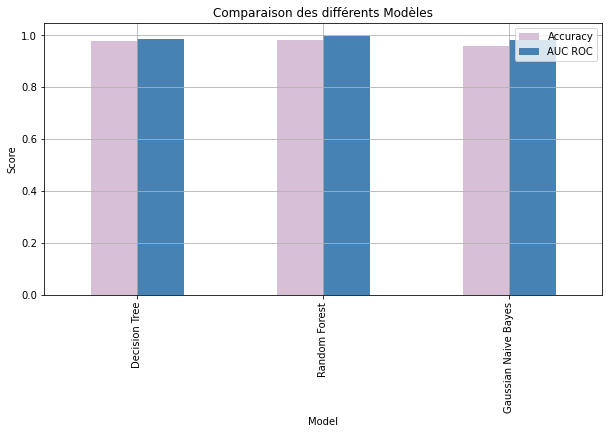

In [30]:
#Plot
model_name = ["Decision Tree", "Random Forest", "Gaussian Naive Bayes"]

fig = plt.figure(figsize=(8, 6))
sd = pd.DataFrame(d, index=[model_name[i] for i in range(len(model_name))] ) 

ax = sd.plot.bar(color=['thistle','steelblue'], figsize=(10,5))
ax.set_ylabel("Score")
ax.set_xlabel("Model")
ax.set_title ("Comparaison des différents Modèles")
ax.grid()
plt.show()

- On voit que Random Forest est le meilleur d'entre les 3 modèles que ce soit en Accuracy ou en AUC ROC.

## II) Using only 5 features (w/o Redshift)


Puisque’on voit dans le cas précedent (avec redshift) que le meilleur est random forest, on ne s'insteressera principalement qu'à lui dans ce cas là. On ne re testera pas Decision Tree Car le score ne peut que baisser en retirant de l'information. Par conre, on re testera Gaussian Bayes pour avoir une idée de son comportement en présence uniquement de features assez correlées.

- On garde une copie pour ne pas avoir à recalculer

In [31]:
X_train6ft = X_train.copy()
X_val6ft = X_val.copy()
X_test6ft = X_test.copy()

Y_train6ft = Y_train.copy()
Y_val6ft = Y_val.copy()
Y_test6ft = Y_test.copy()

- On re-split les données et les réequilibre

In [32]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_temp.drop(columns=['redshift']), labels, test_size = test_ratio)
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, test_size = val_ratio)
print(X_train.head(5))
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

              u         g         r         i         z
67183 -0.326362 -0.079427  0.032262  0.098928  0.150785
17264  0.950264  1.871297  2.008639  2.096206  2.085763
64777  0.643432 -0.117807 -0.524609 -0.667769 -0.798277
83367  0.073107  0.324603  0.467421  0.552552  0.597686
71905  0.635947  0.594342  0.784804  0.876480  0.950040


((56000, 5), (24000, 5), (20000, 5), (56000,), (24000,), (20000,))

In [33]:
X_train, Y_train = resample(X_train, Y_train)
X_val, Y_val = resample(X_val, Y_val)
X_test, Y_test = resample(X_test, Y_test)

  <h3> <ul> 1) Random Forest </ul></h3>


In [34]:
##   Cross validation

model = RandomForestClassifier(max_depth=15, n_estimators = 30, min_samples_leaf=5, random_state=seed) 
score = cross_validate(model, X_train, Y_train,cv=5, scoring='roc_auc_ovr', return_train_score=True)

print("-- Cross Validation : ")
print(f"auc sur l'ensemble d'entrainement : { score['train_score'].mean()} +/- {score['train_score'].std()}")
print(f"auc sur l'ensemble de test : {score['test_score'].mean()} +/- { score['test_score'].std()}")

##   Test sur l'ensemble de validation 

model = RandomForestClassifier(max_depth=15, n_estimators = 30, min_samples_leaf=5, random_state=seed) 

model.fit(X_train, Y_train)
probas = model.predict_proba(X_val)
ypred_val = model.predict(X_val)

## Calcule du score sur val (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

## Calcule de auc roc
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print("-- Score sur validation : ")
print ("RandomForest - accuracy (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("RandomForest - Aire Courbe ROC: ", roc) 

-- Cross Validation : 
auc sur l'ensemble d'entrainement : 0.9973260440870015 +/- 9.005020175589761e-05
auc sur l'ensemble de test : 0.9931589862850242 +/- 0.0004015871671748158
-- Score sur validation : 
RandomForest - accuracy (Nombre d'éléments bien classés/N) :  0.9346786611556852
RandomForest - Aire Courbe ROC:  0.9842594810969977


  <h3> <ul> 2) Gaussian Naive Bayes </ul></h3>


In [35]:
model = BayesienNaif_Gaussian(3)
model.fit(X_train, Y_train)
probas = model.predict_proba(X_val)
ypred_val = model.predict(X_val)

#Calcule du score sur val (Nombre d'elements bien classés/N)
accuracy = 1 - (ypred_val - Y_val != 0 ).mean()

#Metrique AUC ROC
roc = roc_auc_score(Y_val, probas, multi_class='ovr')

print ("Gaussian naive bayes - accuracy (Nombre d'éléments bien classés/N) : ", accuracy) 
print ("Gaussian naive bayes - Aire Courbe ROC : ", roc)

Gaussian naive bayes - accuracy (Nombre d'éléments bien classés/N) :  0.6322500472755761
Gaussian naive bayes - Aire Courbe ROC :  0.8311346427476346


- On voit bien que Gaussian naive baisse fortement en performance. Ce qui ne nous parait pas étonnant puisque l'on a enlevé une feature très importante/informative à la prédiction et que les features restantes ne satisfont pas les hypothèses du modèle Bayesien.

## III) Final model

On voit que dans les 2 cas précedents random forest réussit bien, ce sera donc notre modele final.

On réalisera une optimisation des hyperparamètres puis on affichera les résultats finaux.

  <h3> <ul> Hyperparameters optimization </ul></h3>
On utilisera la méthode GridSearch afin d'optimiser les hyperparamètres de notre modèle. 

Remarque : nous avions testés avec des intervalles plus grand mais vu le temps que ça avait pris, nous avions réduit ces intervales pour se centrer au tour des meilleures valeurs trouvées à chaque fois.   

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

### With redshift

In [37]:
# Prend BEAUCOUP de temps
param_grid = {
    'max_depth': np.arange(15, 35, 5), 
    'n_estimators': np.arange(20, 40, 5),
    'min_samples_leaf':np.arange(2, 5, 2)
}
'''
randomForst6ft = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid, scoring="roc_auc_ovr", cv=5) 
randomForst6ft.fit(X_train6ft, Y_train6ft) # Fit model to data
randomForst6ft.best_params_ 
'''

{'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 30}

In [38]:
#Meilleurs hyperparams ( ils varient à chaque execution : entre 20 et 35 pour max_depth et 30 et 35 pour n_estimators !)
depth_etoile6ft = 25
estimator_etoile6ft = 35
min_samples6ft = 2

In [39]:
model6ft = RandomForestClassifier(max_depth=depth_etoile6ft, n_estimators = estimator_etoile6ft, min_samples_leaf=min_samples6ft, random_state=seed) 
model6ft.fit(X_train6ft, Y_train6ft)
probas6ft = model6ft.predict_proba(X_test6ft)
ypred_test6ft = model6ft.predict(X_test6ft)

### W/o redshift

In [40]:
# Prend beaucoup de temps

param_grid = {
    'max_depth': np.arange(15, 35, 5), 
    'n_estimators': np.arange(20, 40, 5),
    'min_samples_leaf':np.arange(2, 5, 2)
}
'''
randomForst = GridSearchCV(RandomForestClassifier(random_state=seed), param_grid, scoring="roc_auc_ovr", cv=5) 
randomForst.fit(X_train, Y_train) 
randomForst.best_params_ 
'''

{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 35}

In [41]:
#Meilleurs hyperparams 
depth_etoile = 30
estimator_etoile = 35
min_samples =2

In [42]:
model = RandomForestClassifier(max_depth=depth_etoile, n_estimators = estimator_etoile,  min_samples_leaf=min_samples, random_state=seed,) 
model.fit(X_train, Y_train)
probas = model.predict_proba(X_test)
ypred_test = model.predict(X_test)

  <h3> <ul> Results visualizations </ul></h3>


In [43]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

In [44]:
classes = ['GALAXY', 'QSO', 'STAR']

### With redshift

#### Confusion Matrix

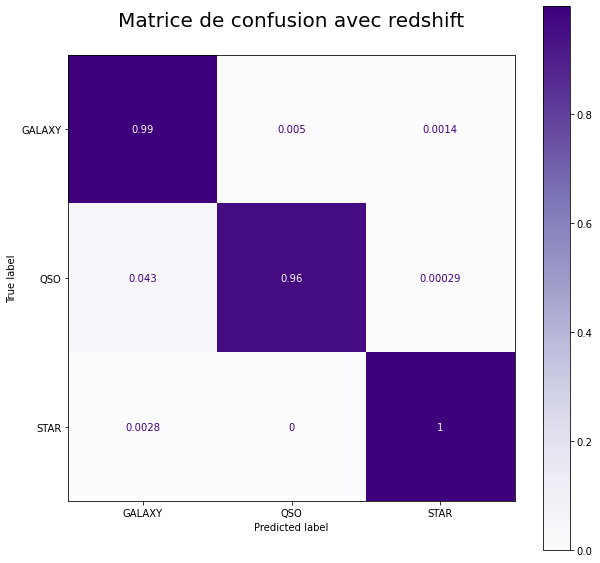

In [45]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model6ft, X_test6ft, Y_test6ft,
                      display_labels=classes,
                      normalize='true',cmap=plt.cm.Purples, ax=ax2)
plt.title('Matrice de confusion avec redshift', y=1.05,fontsize=20)
plt.savefig('Matrice de confusion avec redshift.png') 

#### ROC Curve

In [46]:
#  courbe roc et auc pour chaque classe

Y_test_binarize = label_binarize(Y_test6ft, classes=[0, 1, 2])
n_classes = Y_test_binarize.shape[1]
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( Y_test_binarize[:, i], probas6ft[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


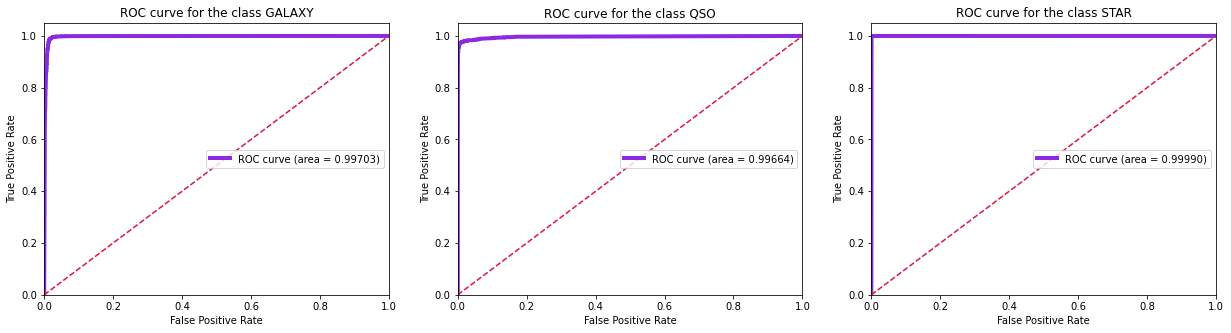

In [47]:
#vicualiation de la courbe roc et auc pour chaque classe 
plt.figure(figsize = (21, 5))

for i in range(n_classes):
    plt.subplot(1,3,i+1)
    plt.plot(fpr[i], tpr[i], color='blueviolet',linewidth=4,label='ROC curve (area = %0.5f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='crimson',linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = ('ROC curve for the class '+ classes[i])
    plt.title(title)
    plt.legend(loc="center right")

In [48]:
#coube ROC pour toutes les classes
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarize.ravel(), probas6ft.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

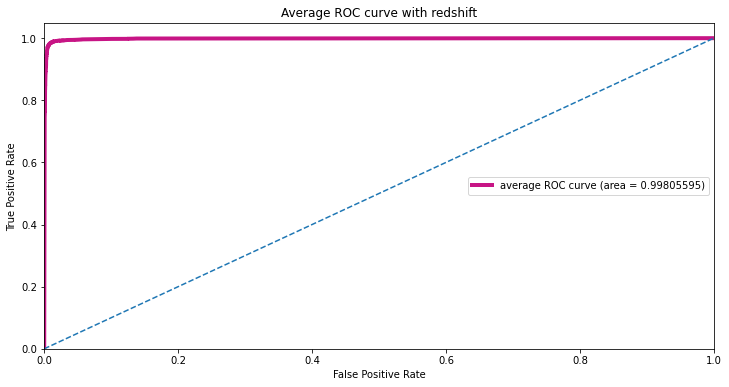

In [49]:
plt.figure(figsize=(12,6))
plt.plot(fpr["micro"], tpr["micro"],label='average ROC curve (area = {0:0.8f})'''.format(roc_auc["micro"]),
         color='mediumvioletred', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC curve with redshift')
plt.legend(loc="center right")

### w/o redshift

#### Confusion Matrix

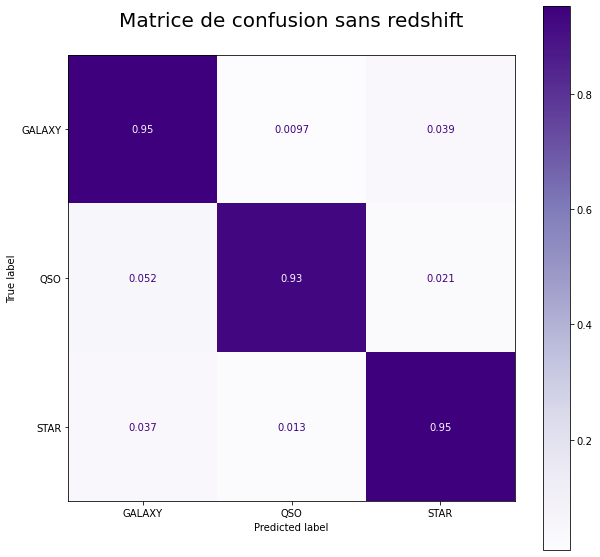

In [50]:
fig3,ax3 = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, Y_test,
                      display_labels=classes,
                      normalize='true',cmap=plt.cm.Purples, ax=ax3)
plt.title('Matrice de confusion sans redshift', y=1.05,fontsize=20)
plt.savefig('Matrice de confusion sans redshift.png')

#### ROC Curve

In [51]:
#  courbe roc et auc pour chaque classe

Y_test_binarize = label_binarize(Y_test, classes=[0, 1, 2])
n_classes = Y_test_binarize.shape[1]
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( Y_test_binarize[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


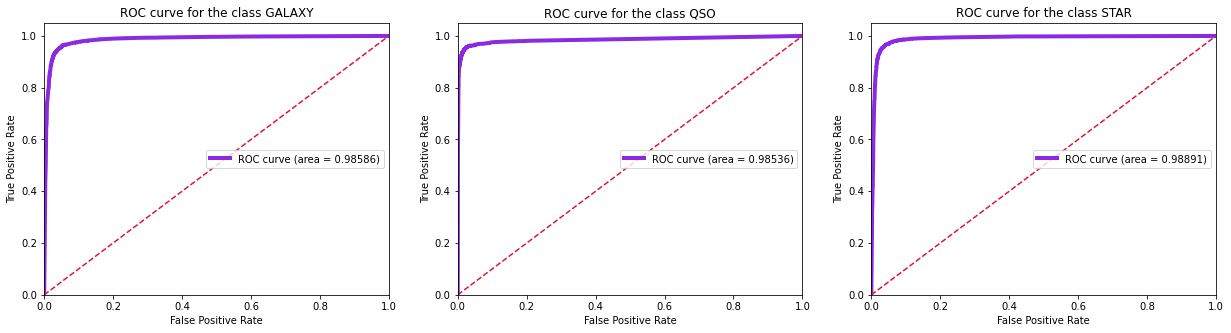

In [52]:
#vicualiation de la courbe roc et auc pour chaque classe 
plt.figure(figsize = (21, 5))
for i in range(n_classes):
    plt.subplot(1,3,i+1)
    plt.plot(fpr[i], tpr[i], color='blueviolet',linewidth=4,label='ROC curve (area = %0.5f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='crimson',linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = ('ROC curve for the class '+ classes[i])
    plt.title(title)
    plt.legend(loc="center right")

In [53]:
#coube ROC pour toutes les classes
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarize.ravel(), probas.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

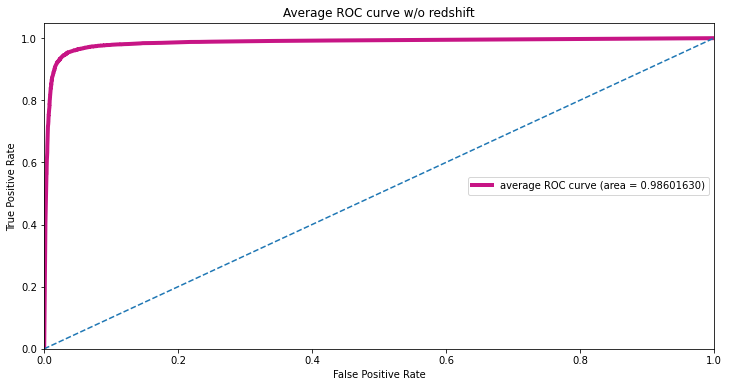

In [54]:
plt.figure(figsize=(12,6))
plt.plot(fpr["micro"], tpr["micro"],label='average ROC curve (area = {0:0.8f})'''.format(roc_auc["micro"]),
         color='mediumvioletred', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC curve w/o redshift')
plt.legend(loc="center right")

### Visualisation des résultats selon les hyperparamètres en dataframe :
#### With redshift

In [55]:
paramsRF6ft = randomForst6ft.cv_results_['params']
mean_scores6ft = randomForst6ft.cv_results_['mean_test_score']
std_scores6ft = randomForst6ft.cv_results_['std_test_score']

In [56]:
n_estimators = []
max_depth = []
min_samples_leaf = []
for l in paramsRF6ft: 
    n_estimators.append(l['n_estimators'])
    max_depth.append(l['max_depth'])
    min_samples_leaf.append(l['min_samples_leaf'])
    
data6ft = {'n_estimators':n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'mean':mean_scores6ft, 'std':std_scores6ft}
   

In [57]:
df6ft = pd.DataFrame(data=data6ft)
df6ft.head(10)

,n_estimators,max_depth,min_samples_leaf,mean,std
0,20,15,2,0.999670,0.000091
1,25,15,2,0.999698,0.000075
2,30,15,2,0.999703,0.000074
3,35,15,2,0.999701,0.000076
4,20,15,4,0.999615,0.000087
5,25,15,4,0.999621,0.000087
6,30,15,4,0.999662,0.000073
7,35,15,4,0.999667,0.000075
8,20,20,2,0.999722,0.000122
9,25,20,2,0.999764,0.000107


#### W/o redshift

In [58]:
paramsRF = randomForst.cv_results_['params']
mean_scores = randomForst.cv_results_['mean_test_score']
std_scores = randomForst.cv_results_['std_test_score']

In [59]:
n_estimators = []
max_depth = []
min_samples_leaf = []
for l in paramsRF: 
    n_estimators.append(l['n_estimators'])
    max_depth.append(l['max_depth'])
    min_samples_leaf.append(l['min_samples_leaf'])
    
data = {'n_estimators':n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'mean':mean_scores, 'std':std_scores}
   

In [60]:
df = pd.DataFrame(data=data)
df.head(10)

,n_estimators,max_depth,min_samples_leaf,mean,std
0,20,15,2,0.993749,0.000515
1,25,15,2,0.993864,0.000438
2,30,15,2,0.994025,0.000453
3,35,15,2,0.994130,0.000416
4,20,15,4,0.993143,0.000467
5,25,15,4,0.993253,0.000409
6,30,15,4,0.993383,0.000435
7,35,15,4,0.993495,0.000452
8,20,20,2,0.995787,0.000299
9,25,20,2,0.995967,0.000281


## Comments

On voit que les résultats obtenus en utilisant un modèle de type Random Forest avec optimisation des hyperparamètres sont assez satisfaisants. On observe que l'on obtient une AUC ROC de 0.995 pour le cas avec redshift, tandis que pour le cas sans redshift on obtient un score de 0.986. Cette baisse est explicable par le fait d'avoir enlevé l'attribut qui comme cité précédemment est très informatif et sert énormément à la prédiction de classe.

D'autres parts, on remarque que le nombre de vrais positifs de la classe Qusar (0.95% / 0.93% pour avec/sans redshift) est plus bas que le nombre de vrais positifs des autres classes (entre 0.99-1% / 0.95% pour avec/sans redshift). Pourtant, la classe de Quasar parait la plus distinguable selon les distributions des features observées au tout début.

Supposition (pas certains): cela pourrait peut-être s'expliquer par le fait que pour avoir le meilleur score d'entre les 3 classes, les seuils de classification fixés pour ce meilleur score impacteraient sur la prédiction de la classe Quasar?

